# Построение модели на примере полиномиальной регрессии (polynomial regression) с использованием `sklearn.pipeline`

## Подготовка окружения

In [ ]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [ ]:
# !conda install matplotlib numpy scikit-learn seaborn scipy -y

In [3]:
import numpy as np

np.__version__

'1.19.2'

In [4]:
import pandas as pd

pd.__version__

'1.2.3'

In [5]:
import scipy
from scipy import stats

scipy.__version__

'1.6.2'

In [6]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.__version__

'3.3.4'

In [7]:
import seaborn as sns

sns.__version__

'0.11.1'

## Загрузка данных

[Источник (Churn Modelling)](https://www.kaggle.com/shrutimechlearn/churn-modelling)

In [8]:
df = pd.read_csv("./../../data/Churn_Modelling.csv", index_col=0)
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


## Преобразование типов и очистка

In [9]:
del df['CustomerId']

In [10]:
df.isna().sum()

Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Surname          10000 non-null  object 
 1   CreditScore      10000 non-null  int64  
 2   Geography        10000 non-null  object 
 3   Gender           10000 non-null  object 
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 1015.6+ KB


In [12]:
for col_name in df.select_dtypes(include='object'):
    print(f'{col_name} : {df[col_name].nunique()}')
    print('-' * 20)

Surname : 2932
--------------------
Geography : 3
--------------------
Gender : 2
--------------------


In [13]:
df['Surname'] = df.Surname.astype('string')
df['Geography'] = df.Geography.astype('string')
df['Gender'] = df.Gender.astype('category')

In [14]:
for col_name in df.select_dtypes(include=int):
    print(f'{col_name} : {df[col_name].nunique()}')
    if df[col_name].nunique() < 40:
        display(df[col_name].value_counts())
    print('-' * 20)

CreditScore : 460
--------------------
Age : 70
--------------------
Tenure : 11


2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

--------------------
NumOfProducts : 4


1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

--------------------
HasCrCard : 2


1    7055
0    2945
Name: HasCrCard, dtype: int64

--------------------
IsActiveMember : 2


1    5151
0    4849
Name: IsActiveMember, dtype: int64

--------------------
Exited : 2


0    7963
1    2037
Name: Exited, dtype: int64

--------------------


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Surname          10000 non-null  string  
 1   CreditScore      10000 non-null  int64   
 2   Geography        10000 non-null  string  
 3   Gender           10000 non-null  category
 4   Age              10000 non-null  int64   
 5   Tenure           10000 non-null  int64   
 6   Balance          10000 non-null  float64 
 7   NumOfProducts    10000 non-null  int64   
 8   HasCrCard        10000 non-null  int64   
 9   IsActiveMember   10000 non-null  int64   
 10  EstimatedSalary  10000 non-null  float64 
 11  Exited           10000 non-null  int64   
dtypes: category(1), float64(2), int64(7), string(2)
memory usage: 947.4 KB


In [16]:
def plot_cat_count_s(cs: pd.Series):
    """
    Функция для рисования countplot для Series
    """
    
    # создать график (сетка 1x1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))

    # создать countplot
    g = sns.countplot(x=cs, 
                      ax=ax)

    # повернуть подписи категорий на 45 градусов
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation=45, 
                      horizontalalignment='right')

    # отключить подпись оси x и y
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    # наименование графика справа цветом графика
    ax.set_title(cs.name, 
                 loc='right', 
                 fontsize=15)

    # включить сетку на графике
    ax.grid()

    # сколько всего записей для всех категорий в колонке
    total = len(cs)
    
    print(f"{total} ({cs.name})")

    # для каждого столбца на графике сверху добавить процент
    for p in ax.patches:
        # вычислить процент, который соответствует текущему столбцу
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)

        # начало (слева) столбца на графике по оси x
        x_pos = p.get_x()

        # верх столбца на графике по оси x
        y_pos = p.get_y() + p.get_height()

        # добавить процент в качестве аннотации к столбцу
        ax.annotate(percentage, 
                    xy=(x_pos, y_pos), 
                    fontsize=15)

10000 (Exited)


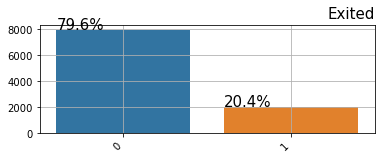

In [17]:
plot_cat_count_s(df.Exited)

Можно сказать, что имеется умеренная (moderate) несбалансированность классов.

## Разделение данных на `X` и `y`

In [18]:
target_column_name = 'Exited'

In [19]:
from sklearn.model_selection import train_test_split

y = df[target_column_name].copy()
X = df.loc[:, df.columns != target_column_name].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Анализ и обработка выбросов

In [20]:
def box_hist(data, col_name):
    _, axs = plt.subplots(1, 2, figsize=(10, 2))
    sns.boxplot(data=data[col_name], ax=axs[0])
    sns.histplot(data=data[col_name], ax=axs[1])

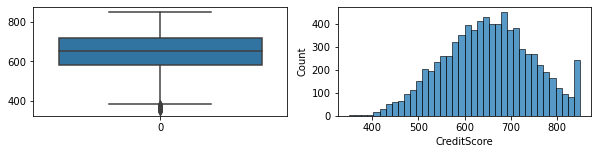

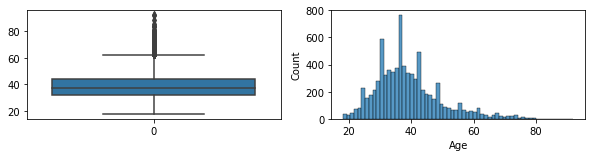

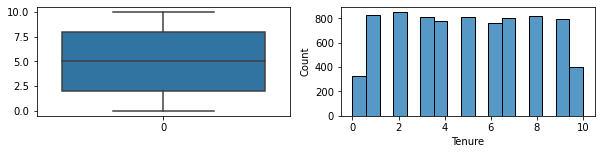

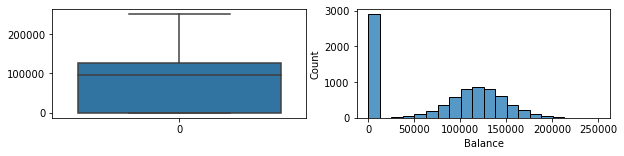

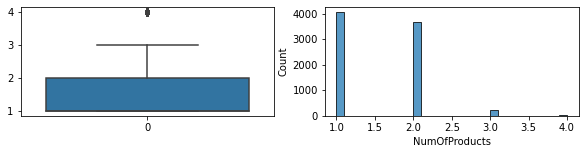

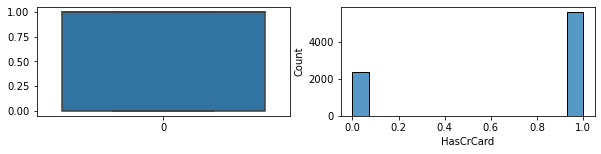

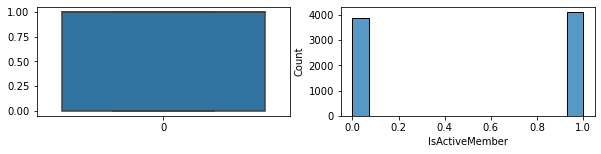

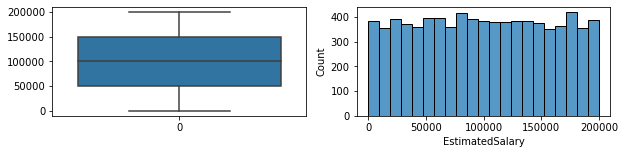

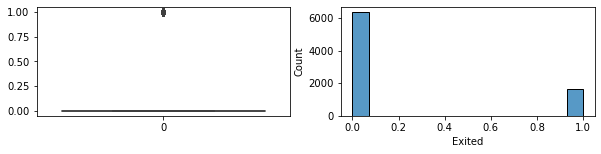

In [21]:
df_tmp = X_train.join(y_train).reset_index(drop=True)
for col_name in df.select_dtypes(include=np.number):
    box_hist(df_tmp, col_name)

X_train = df_tmp.loc[:, df_tmp.columns != target_column_name].copy()
y_train = df_tmp[target_column_name].copy()

In [22]:
# def remove_outliers_iqr(data, col_name):
#     print(f"column name: {col_name}\n")
#     Q1 = data[col_name].quantile(0.25)
#     Q3 = data[col_name].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_fence = Q1 - 1.5 * IQR
#     upper_fence = Q3 + 1.5 * IQR
#     data_new = data#[~((data[col_name] < lower_fence) | (data[col_name] > upper_fence))]

#     diff_len = len(data) - len(data_new)
#     print(f"removed: {diff_len}")

#     _, axs = plt.subplots(1, 2, figsize=(10, 2))
#     sns.boxplot(data=data_new[col_name], ax=axs[0])
#     sns.histplot(data=data_new[col_name], ax=axs[1])

#     return data_new.reset_index(drop=True)

In [23]:
# df_tmp = X_train.join(y_train).reset_index(drop=True)
# print('len(df_tmp) BEFORE:', len(df_tmp))
# for col_name in df.select_dtypes(include=np.number):
#     df_tmp = remove_outliers_iqr(df_tmp, col_name)
#     print("-"*30, '\n')
# print('len(df_tmp) AFTER:', len(df_tmp))

# X_train = df_tmp.loc[:, df_tmp.columns != target_column_name].copy()
# y_train = df_tmp[target_column_name].copy()

## Pipeline

In [24]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [25]:
categorical_transformer = Pipeline(steps=[
#     ('round', FunctionTransformer(lambda x: x.astype(float).round(0))),
#     ('replace', FunctionTransformer(lambda x: x.replace(to_replace={1: 2, 
#                                                                     7: 8, 
#                                                                     8: 6}))),
    ('encoder_oh', OneHotEncoder())
    ])

In [26]:
categorical_columns = X.select_dtypes(include='category').columns.tolist()
categorical_columns

['Gender']

In [27]:
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

In [28]:
numeric_columns = X.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, categorical_columns),
        ('numeric_transformer', numeric_transformer, numeric_columns),
#         ('categorical_FUELTYPE', FUELTYPE_transformer, ['FUELTYPE']),
#         ('numeric_FUELCONSUMPTION_COMB_MPG', numeric_transformer, ['FUELCONSUMPTION_COMB_MPG']),
#         ('drop', 'drop', df.columns.difference(['Geography']).tolist()),
        ('drop', 'drop', ['Geography']),

])

In [36]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model_dtc', DecisionTreeClassifier(criterion="entropy"))
])

# pipeline.get_params()

In [37]:
model = pipeline.fit(X_train, y_train)

In [38]:
# Параметры конвейеров могут быть заданы с использованием имен параметров, разделенных __
param_grid = {
    'model_dtc__max_depth': list(range(1, 15))
}
model_gcv = GridSearchCV(pipeline, param_grid, n_jobs=-1)
model_gcv.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % model_gcv.best_score_)
print(model_gcv.best_params_)

Best parameter (CV score=0.855):
{'model_dtc__max_depth': 5}


In [39]:
from sklearn import set_config                      # to change the display
from sklearn.utils import estimator_html_repr       # to save the diagram into HTML format

# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')

# saving pipeline as html format
with open('./tmp/pipeline.html', 'w') as f:
    f.write(estimator_html_repr(model_gcv.best_estimator_))

# the best estimator from grid search
model_gcv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_transformer',
                                                  Pipeline(steps=[('encoder_oh',
                                                                   OneHotEncoder())]),
                                                  ['Gender']),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('drop', 'drop',
                                                  ['Geography'])])),
                ('model_dtc',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])

## Оценка качества модели (Evaluation)

In [40]:
y_predicted = model_gcv.predict(X_test)

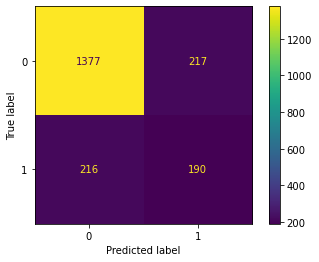

In [41]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test)

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1594
           1       0.74      0.43      0.55       406

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



In [43]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predicted, average='weighted') 

0.8386108721562938

In [44]:
from sklearn.metrics import accuracy_score

print("Accuracy: ", accuracy_score(y_test, y_predicted))

Accuracy:  0.854


## Cross-validation

[sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model_gcv.best_estimator_, X_test, y_test, cv=5)
print(f"scores: {scores}")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

scores: [0.8375 0.825  0.85   0.8775 0.8275]
0.84 accuracy with a standard deviation of 0.02
